In [28]:
import pandas as pd

VARIABLES USED: 
<DEFINE VARIABLES USED HERE>

IMPORTING AND FILTERING DATA FROM CSVs:
WITH TOTAL ROW 

In [23]:
def get_yearly_data_only_total(year):
    medicare = pd.read_csv(f"input/Medicare_{year}.csv",encoding='utf-8')
    no_total= medicare[medicare['Claim Type']=='Total'][["Facility Name", "Facility ID", "State", "Period", 
                                                                        "Claim Type", "Avg Spndg Per EP Hospital"]]
    no_total['year'] = year
    return no_total

WITHOUT TOTAL ROW 

In [24]:
def get_yearly_data_no_total(year):
    medicare = pd.read_csv(f"input/Medicare_{year}.csv",encoding='utf-8')
    #2019 dataset without 'Total'
    no_total= medicare[medicare['Claim Type']!='Total'][["Facility Name", "Facility ID", "State", "Period", 
                                                                        "Claim Type", "Avg Spndg Per EP Hospital"]]
    no_total['year'] = year
    return no_total

LOOPING THROUGH YEARLY DATA BASED ON ABOVE FUNCTIONS AND APPENDING TO EMPTY LIST 

In [25]:
year_data_no_total_temp = []
year_data_only_total_temp = []
for y in [2019,2020,2021,2022]:
    yearly_data_no_total  = get_yearly_data_no_total(y)
    year_data_no_total_temp.append(yearly_data_no_total)

    yearly_data_only_total  = get_yearly_data_only_total(y)
    year_data_only_total_temp.append(yearly_data_only_total)

CONCAT OF 2019 AND 2020 DATA NO TOTAL 

In [26]:
all_data_no_total = pd.concat(year_data_no_total_temp)
all_data_no_total.head()

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,year
0,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Home Health Agency,21,2019
1,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Hospice,1,2019
2,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Inpatient,5,2019
3,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Outpatient,228,2019
4,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,1 to 3 days Prior to Index Hospital Admission,Skilled Nursing Facility,2,2019


CONCAT OF ALL YEARS DATA - ONLY TOTAL

In [36]:
all_data_only_total = pd.concat(year_data_only_total_temp)
all_data_only_total.head()

,Facility Name,Facility ID,State,Period,Claim Type,Avg Spndg Per EP Hospital,year
21,SOUTHEAST ALABAMA MEDICAL CENTER,10001,AL,Complete Episode,Total,23933,2019
43,MARSHALL MEDICAL CENTERS,10005,AL,Complete Episode,Total,19220,2019
65,NORTH ALABAMA MEDICAL CENTER,10006,AL,Complete Episode,Total,21579,2019
87,MIZELL MEMORIAL HOSPITAL,10007,AL,Complete Episode,Total,17180,2019
109,CRENSHAW COMMUNITY HOSPITAL,10008,AL,Complete Episode,Total,16139,2019


USING PIVOT TABLE FUNC TO CREATE A BAR GRAPH (2019 DATA (NO TOTAL), DURING INDEX HOSPITAL ADMISSION, INPATIENT CLAIMS, TOP 5 SPEND HOSP)

In [41]:
inpatient_no_totals = all_data_no_total[(all_data_no_total['Period']=='During Index Hospital Admission') &(all_data_no_total['Claim Type']=='Inpatient')]#
inpatient_no_totals_year = inpatient_no_totals.pivot_table(index='Facility Name', columns='year', values='Avg Spndg Per EP Hospital').sort_values(2019)

<Axes: xlabel='Facility Name'>

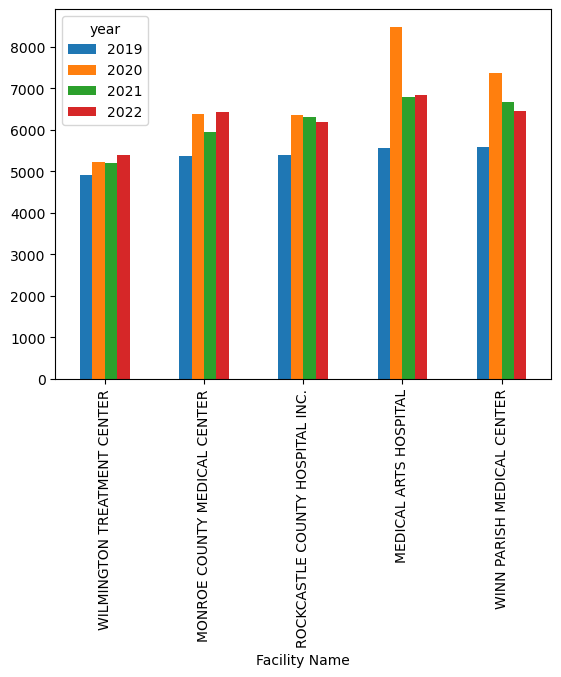

In [42]:
inpatient_no_totals_year.dropna().iloc[:5].plot(kind='bar')

2019 AND 2020 DATA (NO TOTAL) AVG SPENDING PER HOSP FILTERED BY CLAIM TYPE, AND THEN GROUPBY TO CALC AVG SPNDG PER YEAR

In [43]:
no_total_claim_type = all_data_no_total[all_data_no_total['Claim Type'].isin(['Inpatient', 'Hospice'])]
no_total_claim_type.groupby(['Claim Type', 'year'])['Avg Spndg Per EP Hospital'].sum().head()

Claim Type  year
Hospice     2019      494809
            2020      412662
            2021      572899
            2022      635397
Inpatient   2019    37757817
Name: Avg Spndg Per EP Hospital, dtype: int64

2019 AND 2020 AGGREGATE DATA (NO TOTAL) FOR AVG HOSPITAL SPENDING FILTERED BY CLAIM TYPE AND PERIOD 
AND THEN GROUPBY TO CALC AVG SPNDG PER YEAR

In [45]:
hospital_admission = all_data_no_total[(all_data_no_total['Claim Type'] == 'Inpatient') & (all_data_no_total['Period'] == 'During Index Hospital Admission')]
hospital_admission.groupby('year')['Avg Spndg Per EP Hospital'].sum()

year
2019    29624146
2020    27191882
2021    32825494
2022    33355972
Name: Avg Spndg Per EP Hospital, dtype: int64

In [48]:
#If there are more inpatient claims during the period "During Index Hospital Admission" compared to the period "1 to 3 days Prior to
#Index Hospital Admission,it could suggest the following:

#Acute Conditions: It may indicate that patients are being admitted to the hospital for acute medical conditions that require immediate attention 
#and cannot be managed outside of a hospital setting.

#Emergency Situations: The increase in inpatient claims during hospital admission may reflect a higher volume of emergency cases or 
#urgent medical needs that arise suddenly and necessitate hospitalization.

#Severe Symptoms: Patients may be admitted to the hospital when their symptoms become severe or unmanageable, 
#leading to a higher number of inpatient claims during the actual hospital admission period.

#Hospital Procedures: Patients may undergo diagnostic tests, procedures, or surgeries shortly after admission,
#resulting in a surge of inpatient claims during the hospital stay.

#Timely Intervention: It may indicate that patients are receiving timely medical intervention and care 
#upon admission to the hospital, which could potentially improve health outcomes and reduce the risk of complications.

FILTERING/ANALYIZING TOP 5 SPNDG HOSPITALS 

In [50]:
# Function to get top 5 hospitals for each group
def top5_hospitals(group):
    return group.nlargest(5, 'Avg Spndg Per EP Hospital')

yearly_agg = all_data_no_total.groupby(['Facility Name', 'State', 'year']).agg({'Avg Spndg Per EP Hospital': 'sum'}).reset_index()
# Use groupby on the grouped DataFrame, sort values within each group, and pick the top 5
top_hospital = yearly_agg.groupby(['State', 'year']).apply(top5_hospitals).reset_index(drop=True)
top_hospital

,Facility Name,State,year,Avg Spndg Per EP Hospital
0,PROVIDENCE ALASKA MEDICAL CENTER,AK,2019,22095
1,ALASKA REGIONAL HOSPITAL,AK,2019,21053
2,ALASKA NATIVE MEDICAL CENTER,AK,2019,19703
3,MAT-SU REGIONAL MEDICAL CENTER,AK,2019,18334
4,CENTRAL PENINSULA GENERAL HOSPITAL,AK,2019,17274
...,...,...,...,...
995,SUMMIT MEDICAL CENTER,WY,2022,30415
996,WYOMING MEDICAL CENTER,WY,2022,25790
997,CHEYENNE REGIONAL MEDICAL CENTER,WY,2022,22809
998,CAMPBELL COUNTY HEALTH,WY,2022,22474


In [54]:
top_hospital[top_hospital['State']=='NY']

,Facility Name,State,year,Avg Spndg Per EP Hospital
660,WESTCHESTER MEDICAL CENTER,NY,2019,26867
661,MAIMONIDES MEDICAL CENTER,NY,2019,25790
662,MOUNT SINAI HOSPITAL,NY,2019,25587
663,MOUNT SINAI ST LUKE'S ROOSEVELT HOSPITAL,NY,2019,24973
664,NEW YORK UNIVERSITY LANGONE MEDICAL CENTER,NY,2019,24967
665,MOUNT SINAI HOSPITAL,NY,2020,29590
666,RICHMOND UNIVERSITY MEDICAL CENTER,NY,2020,27551
667,NORTHWELL HOSPITAL GLEN COVE,NY,2020,27289
668,ELMHURST HOSPITAL CENTER,NY,2020,26973
669,UNIVERSITY HOSPITAL S U N Y HEALTH SCIENCE CENTER,NY,2020,26925


In [55]:
top_hospital[top_hospital['State']=='CA']

,Facility Name,State,year,Avg Spndg Per EP Hospital
80,GOOD SAMARITAN HOSPITAL,CA,2019,72935
81,ST MARY MEDICAL CENTER,CA,2019,49279
82,ST JOSEPH HOSPITAL,CA,2019,48394
83,GLENDORA COMMUNITY HOSPITAL,CA,2019,33651
84,GREATER EL MONTE COMMUNITY HOSPITAL,CA,2019,32290
85,GOOD SAMARITAN HOSPITAL,CA,2020,69646
86,ST MARY MEDICAL CENTER,CA,2020,43566
87,GREATER EL MONTE COMMUNITY HOSPITAL,CA,2020,39148
88,FOOTHILL REGIONAL MEDICAL CENTER,CA,2020,33404
89,MISSION COMMUNITY HOSPITAL,CA,2020,33219


In [56]:
top_hospital[top_hospital['State']=='TX']

,Facility Name,State,year,Avg Spndg Per EP Hospital
840,NORTHWEST HILLS SURGICAL HOSPITAL,TX,2019,43099
841,WISE HEALTH SYSTEM,TX,2019,38001
842,DALLAS MEDICAL CENTER,TX,2019,36053
843,SURGERY SPECIALTY HOSPITALS OF AMERICA S E HOU...,TX,2019,35975
844,CHI ST LUKES LAKESIDE HOSPITAL,TX,2019,31486
845,DALLAS MEDICAL CENTER,TX,2020,41747
846,SOUTH TEXAS HEALTH SYSTEM,TX,2020,37960
847,METHODIST HOSPITAL FOR SURGERY,TX,2020,36975
848,MEMORIAL HERMANN - TEXAS MEDICAL CENTER,TX,2020,31013
849,BAYLOR SCOTT & WHITE THE HEART HOSPITAL - PLANO,TX,2020,30615


WE NEED A NEW LIST: 

In [181]:
#facility_names = state_concat_top_2019['Facility Name'].tolist()
#facility_names

['HOSPITAL FOR SPECIAL SURGERY',
 'MOUNT SINAI HOSPITAL',
 'WESTCHESTER MEDICAL CENTER',
 'NEW YORK UNIVERSITY LANGONE MEDICAL CENTER',
 'NEW YORK-PRESBYTERIAN HOSPITAL',
 'JACK HUGHSTON MEMORIAL HOSPITAL',
 'UNIVERSITY OF ALABAMA HOSPITAL',
 'SPRINGHILL MEDICAL CENTER',
 'USA HEALTH UNIVERSITY HOSPITAL',
 'GRANDVIEW MEDICAL CENTER',
 'THE SPINE HOSPITAL OF LOUISIANA',
 'STERLING SURGICAL HOSPITAL',
 'PHYSICIANS MEDICAL CENTER',
 'SPECIALISTS HOSPITAL SHREVEPORT',
 'CYPRESS POINTE SURGICAL HOSPITAL',
 'SUMMIT MEDICAL CENTER',
 'CAMPBELL COUNTY HEALTH',
 'WYOMING MEDICAL CENTER',
 'ST JOHNS MEDICAL CENTER',
 'CHEYENNE REGIONAL MEDICAL CENTER',
 'MIDWESTERN REGION MED CENTER',
 'NORTHWESTERN MEMORIAL HOSPITAL',
 'UNIVERSITY OF ILLINOIS HOSPITAL',
 'RUSH UNIVERSITY MEDICAL CENTER',
 'LOYOLA UNIVERSITY MEDICAL CENTER',
 'SWEDISH MEDICAL CENTER / CHERRY HILL',
 'HARBORVIEW MEDICAL CENTER',
 'UNIVERSITY OF WASHINGTON MEDICAL CTR',
 'PROV SACRED HRT MED CTR & CHILDS HOSP.',
 'ST JOSEPH MEDICA

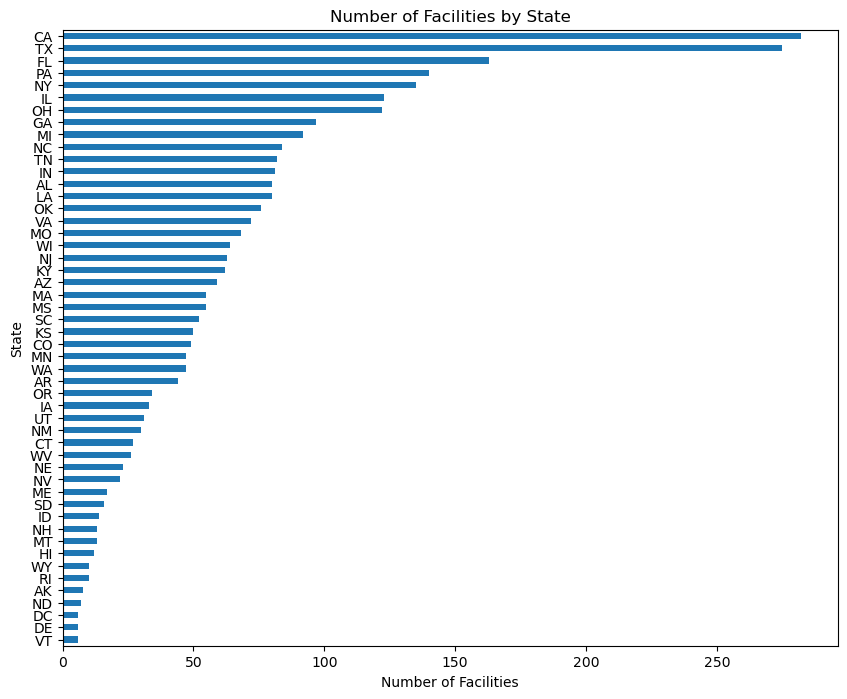

In [32]:
import matplotlib.pyplot as plt

df2019 = get_yearly_data_only_total(2019)

# Assuming df is your DataFrame containing the data
# Group data by State and count the number of unique facilities
facility_counts_by_state = df2019.groupby('State')['Facility ID'].nunique().sort_values()

# Plot horizontal bar chart to visualize proportion of facilities by state
plt.figure(figsize=(10, 8))
facility_counts_by_state.plot(kind='barh')
plt.xlabel('Number of Facilities')
plt.ylabel('State')
plt.title('Number of Facilities by State')
plt.show()

In [35]:
import seaborn as sns

SpendingPerState = df2019.groupby('State')['Avg Spndg Per EP Hospital'].sum().sort_values()

SeriesIndices = SpendingPerState.head().index[:]
BottomStatesSpendingList = SeriesIndices.tolist()


AvgSpendingvsStateGraph = sns.barplot(x = df2019['State'], y = df2019['Avg Spndg Per EP Hospital'], order = BottomStatesSpendingList)
for element in AvgSpendingvsStateGraph.get_xticklabels():
    element.set_rotation(90)

NameError: name 'sns' is not defined